In [1]:
%matplotlib inline
import pandas as pd
import statsmodels.api as sm
import itertools
import matplotlib.pyplot as plt
from fbprophet import Prophet
import optuna
import mlflow
from statsmodels.tsa.ar_model import AutoReg

In [2]:
data = pd.read_csv('./per_liter_clean.csv')

In [3]:
data.dtypes

Unnamed:_0                         int64
DATA_INICIAL                      object
DATA_FINAL                        object
REGIAO                            object
ESTADO                            object
PRODUTO                           object
NUMERO_DE_POSTOS_PESQUISADOS       int64
UNIDADE_DE_MEDIDA                 object
PRECO_MEDIO_REVENDA              float64
DESVIO_PADRAO_REVENDA            float64
PRECO_MINIMO_REVENDA             float64
PRECO_MAXIMO_REVENDA             float64
MARGEM_MEDIA_REVENDA             float64
COEF_DE_VARIACAO_REVENDA         float64
PRECO_MEDIO_DISTRIBUICAO         float64
DESVIO_PADRAO_DISTRIBUICAO       float64
PRECO_MINIMO_DISTRIBUICAO        float64
PRECO_MAXIMO_DISTRIBUICAO        float64
COEF_DE_VARIACAO_DISTRIBUICAO    float64
MES                                int64
ANO                                int64
dtype: object

In [4]:
data['DATA_INICIAL'] = pd.to_datetime(data['DATA_INICIAL'])
data['DATA_FINAL'] = pd.to_datetime(data['DATA_FINAL'])

In [5]:
for colname in ['REGIAO', 'ESTADO', 'PRODUTO']:
    data[colname] = data[colname].astype('category')

data[['REGIAO', 'ESTADO', 'PRODUTO']].dtypes

REGIAO     category
ESTADO     category
PRODUTO    category
dtype: object

Os dados lidos apresentam vários estados e produtos, implicando diferentes previsões para cada. Nos atendo aos propósitos deste projeto, preveremos somente para Pernambuco e o produto mais comum.

In [6]:
data['ESTADO'].unique()

['DISTRITO FEDERAL', 'GOIAS', 'MATO GROSSO', 'MATO GROSSO DO SUL', 'ALAGOAS', ..., 'SAO PAULO', 'PARANA', 'RIO GRANDE DO SUL', 'SANTA CATARINA', 'PARA']
Length: 27
Categories (27, object): ['DISTRITO FEDERAL', 'GOIAS', 'MATO GROSSO', 'MATO GROSSO DO SUL', ..., 'PARANA', 'RIO GRANDE DO SUL', 'SANTA CATARINA', 'PARA']

In [7]:
data_pern = data[data['ESTADO'] == 'PERNAMBUCO']
len(data_pern)

2645

In [8]:
for p in data_pern['PRODUTO'].unique():
    print(f'Quantidade de {p}: {(data_pern["PRODUTO"] == p).sum()}')

Quantidade de ETANOL HIDRATADO: 782
Quantidade de GASOLINA COMUM: 749
Quantidade de ÓLEO DIESEL: 776
Quantidade de ÓLEO DIESEL S10: 338


In [9]:
data_pern = data_pern[data_pern['PRODUTO'] == 'ETANOL HIDRATADO']

In [10]:
data_pern.index = data_pern['DATA_INICIAL']

Preveremos o preço médio de revenda, utilizando ARIMA inicialmente

In [11]:
data_pern.index.max()

Timestamp('2019-06-23 00:00:00')

Dado que temos informações desde 2004 até o final do primeiro semestre de 2019, podemos dividir os dados em treinamento até o final do primeiro semestre de 2018, validação desse ponto até o final do segundo semestre de 2018, e teste o que resta. Vamos também obter os dados médios por mês, para poder usar 12 como parâmetro de sazonalidade do SARIMAX.

In [12]:
data_pern = data_pern.resample('m').mean()

In [13]:
data_pern_train = data_pern[:'2018-06']
data_pern_validation = data_pern['2018-07':'2018-12']
data_pern_test = data_pern['2019-01':'2019-06']

<AxesSubplot:xlabel='DATA_INICIAL'>

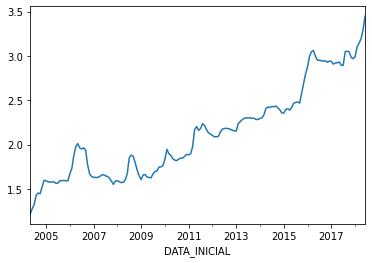

In [14]:
data_pern_train['PRECO_MEDIO_REVENDA'].plot()

<AxesSubplot:xlabel='DATA_INICIAL'>

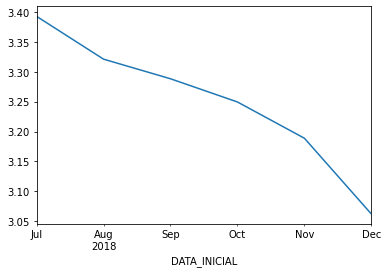

In [15]:
data_pern_validation['PRECO_MEDIO_REVENDA'].plot()

<AxesSubplot:xlabel='DATA_INICIAL'>

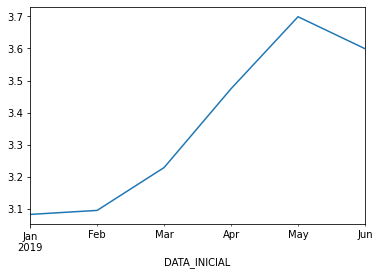

In [16]:
data_pern_test['PRECO_MEDIO_REVENDA'].plot()

Vamos agora realizar uma grid-search para determinar os melhores parâmetros para o algoritmo

In [17]:
y = data_pern_train['PRECO_MEDIO_REVENDA']

In [18]:
def objective(trial):
    p = trial.suggest_int('p', 0, 2)
    d = trial.suggest_int('d', 0, 2)
    q = trial.suggest_int('q', 0, 2)

    ps = trial.suggest_int('ps', 0, 2)
    ds = trial.suggest_int('ds', 0, 2)
    qs = trial.suggest_int('qs', 0, 0)

    mdl = sm.tsa.statespace.SARIMAX(
        y,
        order=(p, d, q),
        seasonal_order=(ps, ds, qs, 12),
        enforce_stationarity=False,
        enforce_invertibility=False
    )

    results = mdl.fit()

    trial.report(results.aic, 0)

    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()

    return results.aic

In [19]:
def print_study_best_trial_params(study):
    t = study.best_trial

    print(f'Melhor valor: {t.value}')

    print(f'Melhores parâmetros:')

    for p, v in t.params.items():
        print(f'{p}: {v}')

In [20]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=300)

print_study_best_trial_params(study)

[I 2021-04-17 14:21:51,476] A new study created in memory with name: no-name-b8a6caec-be89-43f7-9bae-93c0a823dc02
[I 2021-04-17 14:21:51,647] Trial 0 finished with value: -208.887276596734 and parameters: {'p': 1, 'd': 2, 'q': 0, 'ps': 0, 'ds': 2, 'qs': 0}. Best is trial 0 with value: -208.887276596734.
[I 2021-04-17 14:21:52,849] Trial 1 finished with value: -319.6641505513497 and parameters: {'p': 0, 'd': 1, 'q': 2, 'ps': 2, 'ds': 2, 'qs': 0}. Best is trial 1 with value: -319.6641505513497.
[I 2021-04-17 14:21:53,063] Trial 2 finished with value: -242.11232805411802 and parameters: {'p': 2, 'd': 1, 'q': 1, 'ps': 0, 'ds': 2, 'qs': 0}. Best is trial 1 with value: -319.6641505513497.
[I 2021-04-17 14:21:53,303] Trial 3 finished with value: -450.3160068293978 and parameters: {'p': 1, 'd': 0, 'q': 2, 'ps': 1, 'ds': 1, 'qs': 0}. Best is trial 3 with value: -450.3160068293978.
/home/co/miniconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likeliho

[I 2021-04-17 14:22:03,333] Trial 45 finished with value: -580.3521165454284 and parameters: {'p': 2, 'd': 0, 'q': 1, 'ps': 0, 'ds': 0, 'qs': 0}. Best is trial 39 with value: -580.3521165454284.
[I 2021-04-17 14:22:03,436] Trial 46 finished with value: -580.3521165454284 and parameters: {'p': 2, 'd': 0, 'q': 1, 'ps': 0, 'ds': 0, 'qs': 0}. Best is trial 39 with value: -580.3521165454284.
[I 2021-04-17 14:22:03,542] Trial 47 finished with value: -580.3521165454284 and parameters: {'p': 2, 'd': 0, 'q': 1, 'ps': 0, 'ds': 0, 'qs': 0}. Best is trial 39 with value: -580.3521165454284.
[I 2021-04-17 14:22:03,652] Trial 48 finished with value: -580.3521165454284 and parameters: {'p': 2, 'd': 0, 'q': 1, 'ps': 0, 'ds': 0, 'qs': 0}. Best is trial 39 with value: -580.3521165454284.
[I 2021-04-17 14:22:03,985] Trial 49 pruned. 
[I 2021-04-17 14:22:04,235] Trial 50 pruned. 
[I 2021-04-17 14:22:04,361] Trial 51 finished with value: -580.3521165454284 and parameters: {'p': 2, 'd': 0, 'q': 1, 'ps': 0, '

[I 2021-04-17 14:22:09,313] Trial 91 finished with value: -580.3521165454284 and parameters: {'p': 2, 'd': 0, 'q': 1, 'ps': 0, 'ds': 0, 'qs': 0}. Best is trial 39 with value: -580.3521165454284.
[I 2021-04-17 14:22:09,405] Trial 92 finished with value: -580.3521165454284 and parameters: {'p': 2, 'd': 0, 'q': 1, 'ps': 0, 'ds': 0, 'qs': 0}. Best is trial 39 with value: -580.3521165454284.
[I 2021-04-17 14:22:09,531] Trial 93 finished with value: -580.3521165454284 and parameters: {'p': 2, 'd': 0, 'q': 1, 'ps': 0, 'ds': 0, 'qs': 0}. Best is trial 39 with value: -580.3521165454284.
[I 2021-04-17 14:22:09,690] Trial 94 finished with value: -580.3521165454284 and parameters: {'p': 2, 'd': 0, 'q': 1, 'ps': 0, 'ds': 0, 'qs': 0}. Best is trial 39 with value: -580.3521165454284.
[I 2021-04-17 14:22:09,784] Trial 95 finished with value: -580.3521165454284 and parameters: {'p': 2, 'd': 0, 'q': 1, 'ps': 0, 'ds': 0, 'qs': 0}. Best is trial 39 with value: -580.3521165454284.
[I 2021-04-17 14:22:09,87

[I 2021-04-17 14:22:14,392] Trial 134 finished with value: -580.3521165454284 and parameters: {'p': 2, 'd': 0, 'q': 1, 'ps': 0, 'ds': 0, 'qs': 0}. Best is trial 39 with value: -580.3521165454284.
[I 2021-04-17 14:22:14,486] Trial 135 finished with value: -580.3521165454284 and parameters: {'p': 2, 'd': 0, 'q': 1, 'ps': 0, 'ds': 0, 'qs': 0}. Best is trial 39 with value: -580.3521165454284.
[I 2021-04-17 14:22:14,581] Trial 136 finished with value: -580.3521165454284 and parameters: {'p': 2, 'd': 0, 'q': 1, 'ps': 0, 'ds': 0, 'qs': 0}. Best is trial 39 with value: -580.3521165454284.
[I 2021-04-17 14:22:14,675] Trial 137 finished with value: -580.3521165454284 and parameters: {'p': 2, 'd': 0, 'q': 1, 'ps': 0, 'ds': 0, 'qs': 0}. Best is trial 39 with value: -580.3521165454284.
[I 2021-04-17 14:22:14,769] Trial 138 finished with value: -580.3521165454284 and parameters: {'p': 2, 'd': 0, 'q': 1, 'ps': 0, 'ds': 0, 'qs': 0}. Best is trial 39 with value: -580.3521165454284.
[I 2021-04-17 14:22:

[I 2021-04-17 14:22:18,913] Trial 174 finished with value: -580.3521165454284 and parameters: {'p': 2, 'd': 0, 'q': 1, 'ps': 0, 'ds': 0, 'qs': 0}. Best is trial 39 with value: -580.3521165454284.
[I 2021-04-17 14:22:19,042] Trial 175 finished with value: -580.3521165454284 and parameters: {'p': 2, 'd': 0, 'q': 1, 'ps': 0, 'ds': 0, 'qs': 0}. Best is trial 39 with value: -580.3521165454284.
[I 2021-04-17 14:22:19,159] Trial 176 finished with value: -580.3521165454284 and parameters: {'p': 2, 'd': 0, 'q': 1, 'ps': 0, 'ds': 0, 'qs': 0}. Best is trial 39 with value: -580.3521165454284.
[I 2021-04-17 14:22:19,271] Trial 177 finished with value: -580.3521165454284 and parameters: {'p': 2, 'd': 0, 'q': 1, 'ps': 0, 'ds': 0, 'qs': 0}. Best is trial 39 with value: -580.3521165454284.
[I 2021-04-17 14:22:19,378] Trial 178 finished with value: -580.3521165454284 and parameters: {'p': 2, 'd': 0, 'q': 1, 'ps': 0, 'ds': 0, 'qs': 0}. Best is trial 39 with value: -580.3521165454284.
[I 2021-04-17 14:22:

[I 2021-04-17 14:22:23,453] Trial 216 finished with value: -580.3521165454284 and parameters: {'p': 2, 'd': 0, 'q': 1, 'ps': 0, 'ds': 0, 'qs': 0}. Best is trial 39 with value: -580.3521165454284.
[I 2021-04-17 14:22:23,569] Trial 217 finished with value: -580.3521165454284 and parameters: {'p': 2, 'd': 0, 'q': 1, 'ps': 0, 'ds': 0, 'qs': 0}. Best is trial 39 with value: -580.3521165454284.
[I 2021-04-17 14:22:23,684] Trial 218 finished with value: -580.3521165454284 and parameters: {'p': 2, 'd': 0, 'q': 1, 'ps': 0, 'ds': 0, 'qs': 0}. Best is trial 39 with value: -580.3521165454284.
[I 2021-04-17 14:22:23,847] Trial 219 finished with value: -580.3521165454284 and parameters: {'p': 2, 'd': 0, 'q': 1, 'ps': 0, 'ds': 0, 'qs': 0}. Best is trial 39 with value: -580.3521165454284.
[I 2021-04-17 14:22:23,958] Trial 220 finished with value: -580.3521165454284 and parameters: {'p': 2, 'd': 0, 'q': 1, 'ps': 0, 'ds': 0, 'qs': 0}. Best is trial 39 with value: -580.3521165454284.
[I 2021-04-17 14:22:

[I 2021-04-17 14:22:29,047] Trial 259 pruned. 
[I 2021-04-17 14:22:29,159] Trial 260 finished with value: -580.3521165454284 and parameters: {'p': 2, 'd': 0, 'q': 1, 'ps': 0, 'ds': 0, 'qs': 0}. Best is trial 39 with value: -580.3521165454284.
[I 2021-04-17 14:22:29,294] Trial 261 finished with value: -580.3521165454284 and parameters: {'p': 2, 'd': 0, 'q': 1, 'ps': 0, 'ds': 0, 'qs': 0}. Best is trial 39 with value: -580.3521165454284.
[I 2021-04-17 14:22:29,441] Trial 262 finished with value: -580.3521165454284 and parameters: {'p': 2, 'd': 0, 'q': 1, 'ps': 0, 'ds': 0, 'qs': 0}. Best is trial 39 with value: -580.3521165454284.
[I 2021-04-17 14:22:29,627] Trial 263 finished with value: -580.3521165454284 and parameters: {'p': 2, 'd': 0, 'q': 1, 'ps': 0, 'ds': 0, 'qs': 0}. Best is trial 39 with value: -580.3521165454284.
[I 2021-04-17 14:22:29,882] Trial 264 pruned. 
[I 2021-04-17 14:22:29,994] Trial 265 finished with value: -580.3521165454284 and parameters: {'p': 2, 'd': 0, 'q': 1, 'ps

Melhor valor: -580.3521165454284
Melhores parâmetros:
p: 2
d: 0
q: 1
ps: 0
ds: 0
qs: 0


Determinados os melhores parâmetros, vamos treinar o nosso modelo e realizar uma previsão

In [21]:
pdq = (2, 0, 1)
pdqs = (0, 0, 0, 12)

mod = sm.tsa.statespace.SARIMAX(
    y,
    order=pdq,
    seasonal_order=pdqs,
    enforce_stationarity=False,
    enforce_invertibility=False
)

res = mod.fit()

In [22]:
mlflow.log_params({ "sarimax_pdq": pdq, "sarimax_pdqs": pdqs })
mlflow.statsmodels.log_model(res, "sarimax")

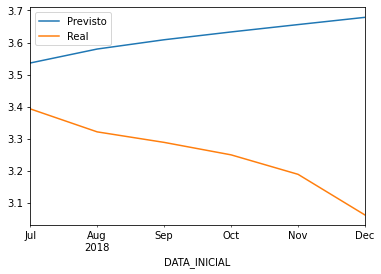

In [23]:
predicted = res.get_prediction(start='2018-07', end='2018-12')
predicted.predicted_mean.plot(label='Previsto')
data_pern_validation['PRECO_MEDIO_REVENDA'].plot(label='Real')
plt.legend()

Repitamos a previsão para o intervalo de tempo de teste

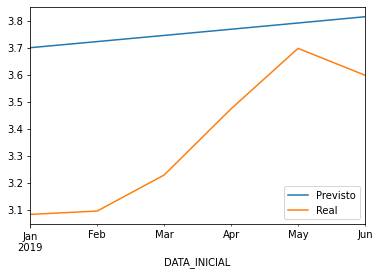

In [24]:
predicted_test = res.get_prediction(start = '2019-01', end='2019-06')
predicted_test.predicted_mean.plot(label='Previsto')
data_pern_test['PRECO_MEDIO_REVENDA'].plot(label='Real')
plt.legend()

MSE (Mean Squared Error):

In [25]:
sarimax_mse = ((predicted_test.predicted_mean - data_pern_test['PRECO_MEDIO_REVENDA']) ** 2).mean()
sarimax_mse

0.19769325390690984

In [26]:
mlflow.log_metric('sarimax_mse', sarimax_mse)

### Prophet

In [27]:
prophet_df = pd.DataFrame()
prophet_df['y'] = data_pern_train['PRECO_MEDIO_REVENDA']
prophet_df['ds'] = data_pern_train.index

<AxesSubplot:xlabel='ds'>

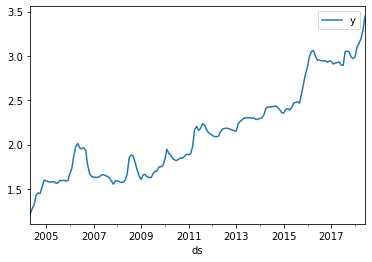

In [28]:
prophet_df.plot(x='ds')

In [29]:
def prophet_objective(trial):
    changepoint_prior_scale = trial.suggest_float('changepoint_prior_scale', .001, .5)
    seasonality_prior_scale = trial.suggest_float('seasonality_prior_scale', .01, 10)
    holidays_prior_scale = trial.suggest_float('holidays_prior_scale', .01, 10)

    prophet = Prophet(
        changepoint_prior_scale=changepoint_prior_scale,
        seasonality_prior_scale=seasonality_prior_scale,
        holidays_prior_scale=holidays_prior_scale
    )

    prophet.fit(prophet_df)

    future_df = prophet.make_future_dataframe(periods=6, freq='m')
    future_pred = prophet.predict(future_df)

    mse = ((future_pred[-6:]['yhat'].reset_index(drop=True) - data_pern_validation['PRECO_MEDIO_REVENDA'].reset_index(drop=True)) ** 2).mean()

    trial.report(mse, 0)

    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()

    return mse

In [30]:
prophet_study = optuna.create_study(direction="minimize")
prophet_study.optimize(prophet_objective, n_trials=80)

print_study_best_trial_params(prophet_study)

[I 2021-04-17 14:22:36,277] A new study created in memory with name: no-name-466fcfbc-015d-4ee9-870d-a619da01af51
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[I 2021-04-17 14:22:39,068] Trial 0 finished with value: 0.016802631759485407 and parameters: {'changepoint_prior_scale': 0.12069023372147518, 'seasonality_prior_scale': 5.0562445708415975, 'holidays_prior_scale': 2.7049345199763875}. Best is trial 0 with value: 0.016802631759485407.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[I 2021-04-17 14:22:40,755] Trial 1 finished with value: 0.014084242310780476 and parameters: {'changepoint_prior_scale': 0.03640886765558087, 'seasonality_prior_scale': 8.16285516047459, '

[I 2021-04-17 14:23:11,716] Trial 20 finished with value: 0.01452382009724331 and parameters: {'changepoint_prior_scale': 0.4978331142483988, 'seasonality_prior_scale': 8.32241867148154, 'holidays_prior_scale': 2.025279000351974}. Best is trial 1 with value: 0.014084242310780476.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[I 2021-04-17 14:23:13,251] Trial 21 finished with value: 0.014220023409445825 and parameters: {'changepoint_prior_scale': 0.045385928356593275, 'seasonality_prior_scale': 5.266182046868647, 'holidays_prior_scale': 7.221313418531064}. Best is trial 1 with value: 0.014084242310780476.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[I 2021-04-17 14:23:14

[I 2021-04-17 14:23:49,744] Trial 44 pruned. 
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[I 2021-04-17 14:23:51,400] Trial 45 pruned. 
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[I 2021-04-17 14:23:53,075] Trial 46 finished with value: 0.014139810711772735 and parameters: {'changepoint_prior_scale': 0.03237329367610777, 'seasonality_prior_scale': 5.835584246133212, 'holidays_prior_scale': 2.209289359226567}. Best is trial 35 with value: 0.013949480437517625.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[I 20

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[I 2021-04-17 14:24:31,355] Trial 70 pruned. 
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[I 2021-04-17 14:24:32,827] Trial 71 pruned. 
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[I 2021-04-17 14:24:34,249] Trial 72 pruned. 
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[I 2021-04-17 14:24:36,541] Trial 73 p

Melhor valor: 0.013949480437517625
Melhores parâmetros:
changepoint_prior_scale: 0.0361838570185534
seasonality_prior_scale: 7.571372865671984
holidays_prior_scale: 2.037212869060806


In [31]:
prophet = Prophet(**prophet_study.best_trial.params)
prophet.fit(prophet_df)
future_df = prophet.make_future_dataframe(periods=6, freq='m')
future_pred = prophet.predict(future_df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [32]:
last_6_months = future_pred[-6:].reset_index(drop=True)
last_6_months.index = data_pern_test.index

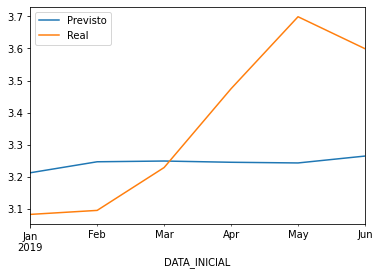

In [33]:
last_6_months['yhat'].plot(label='Previsto')
data_pern_test['PRECO_MEDIO_REVENDA'].plot(label='Real')
plt.legend()

In [34]:
prophet_mse = ((future_pred[-6:]['yhat'].reset_index(drop=True) - data_pern_test['PRECO_MEDIO_REVENDA'].reset_index(drop=True)) ** 2).mean()
prophet_mse

0.06854647912456395

In [35]:
for name, value in prophet_study.best_trial.params.items():
    mlflow.log_param(f'fbprophet_{name}', value)
mlflow.sklearn.log_model(prophet, 'prophet')
mlflow.log_metric('prophet_mse', prophet_mse)

**Auto Regression**

In [36]:
ar_y = data_pern_train['PRECO_MEDIO_REVENDA']

In [37]:
from statsmodels.tsa.ar_model import AutoReg

def ar_objective(trial):
    mdl = AutoReg(ar_y, lags=trial.suggest_int('lags', 0, 6))
    
    res = mdl.fit()
    
    aic = res.aic
    
    trial.report(aic, 0)
    
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()
        
    return aic

In [38]:
ar_study = optuna.create_study(direction="minimize")
ar_study.optimize(ar_objective, n_trials=10)

print_study_best_trial_params(ar_study)

[I 2021-04-17 14:24:48,247] A new study created in memory with name: no-name-d38b7be9-0b1f-4c76-b11c-4ac3468ac1ea
[I 2021-04-17 14:24:48,268] Trial 0 finished with value: -6.278137971701282 and parameters: {'lags': 3}. Best is trial 0 with value: -6.278137971701282.
[I 2021-04-17 14:24:48,395] Trial 1 finished with value: -1.315869933536712 and parameters: {'lags': 0}. Best is trial 0 with value: -6.278137971701282.
[I 2021-04-17 14:24:48,399] Trial 2 finished with value: -5.994109141226578 and parameters: {'lags': 1}. Best is trial 0 with value: -6.278137971701282.
[I 2021-04-17 14:24:48,403] Trial 3 finished with value: -6.282334891672952 and parameters: {'lags': 4}. Best is trial 3 with value: -6.282334891672952.
[I 2021-04-17 14:24:48,407] Trial 4 finished with value: -5.994109141226578 and parameters: {'lags': 1}. Best is trial 3 with value: -6.282334891672952.
[I 2021-04-17 14:24:48,412] Trial 5 finished with value: -6.282334891672952 and parameters: {'lags': 4}. Best is trial 3 

Melhor valor: -6.282334891672952
Melhores parâmetros:
lags: 4


In [39]:
ar_mdl = AutoReg(ar_y, **ar_study.best_trial.params)
ar_res = ar_mdl.fit()

In [40]:
mlflow.log_param('ar_lags', ar_study.best_trial.params['lags'])
mlflow.statsmodels.log_model(ar_res, 'autoregression')

Os parâmetros de previsão para o modelo de autoregressão são os índices de início e fim da previsão. Como desejamos prever 6 meses, devemos fornecer o índice do último item mais um, que é o mesmo que o tamanho de ar_y, e o índice do sexto mês a partir do fim

In [41]:
prediction = ar_res.predict(start=len(ar_y), end=len(ar_y) + 5)
prediction

2018-07-31    3.533821
2018-08-31    3.571089
2018-09-30    3.592936
2018-10-31    3.613910
2018-11-30    3.636479
2018-12-31    3.659985
Freq: M, dtype: float64

In [42]:
prediction.index = data_pern_test.index

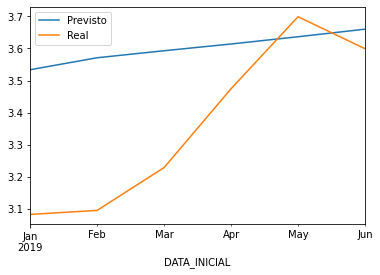

In [43]:
prediction.plot(label='Previsto')
data_pern_test['PRECO_MEDIO_REVENDA'].plot(label='Real')
plt.legend()

In [44]:
ar_mse = ((data_pern_test['PRECO_MEDIO_REVENDA'] - prediction) ** 2).mean()
ar_mse

0.09793155747593428

In [45]:
mlflow.log_metric('ar_mse', ar_mse)

### Holt Winter's Exponential Smoothing

In [46]:
hwes_y = data_pern_train['PRECO_MEDIO_REVENDA']

In [47]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [48]:
def hwes_objective(trial):
    component_type = {"additive", "multiplicative", None}
    
    mdl = ExponentialSmoothing(
        hwes_y,
        seasonal=trial.suggest_categorical("seasonal", component_type),
        trend=trial.suggest_categorical("trend", component_type)
    )
    
    res = mdl.fit()
    
    aic = res.aic
    
    trial.report(aic, 0)
    
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()
        
    return aic

In [49]:
hwes_study = optuna.create_study(direction="minimize")
hwes_study.optimize(hwes_objective, n_trials=9)

print_study_best_trial_params(hwes_study)

[I 2021-04-17 14:24:49,335] A new study created in memory with name: no-name-46df5fd1-c762-4e6b-9f02-de160478d5c5
[I 2021-04-17 14:24:49,392] Trial 0 finished with value: -1024.10824212834 and parameters: {'seasonal': None, 'trend': 'multiplicative'}. Best is trial 0 with value: -1024.10824212834.
[I 2021-04-17 14:24:49,399] Trial 1 finished with value: -1009.6077505392568 and parameters: {'seasonal': None, 'trend': None}. Best is trial 0 with value: -1024.10824212834.
/home/co/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",
[I 2021-04-17 14:24:49,424] Trial 2 finished with value: -878.4339811838091 and parameters: {'seasonal': 'multiplicative', 'trend': None}. Best is trial 0 with value: -1024.10824212834.
/home/co/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization faile

Melhor valor: -1030.2756647449069
Melhores parâmetros:
seasonal: None
trend: additive


In [50]:
hwes_model = ExponentialSmoothing(hwes_y, **hwes_study.best_trial.params)
hwes_res = hwes_model.fit()

In [51]:
mlflow.log_param('hwes_trend', hwes_study.best_trial.params['trend'])
mlflow.statsmodels.log_model(hwes_res, 'hwes')

In [52]:
prediction = hwes_res.predict(start=len(hwes_y), end=(len(hwes_y) + 5))
prediction.index = data_pern_test.index

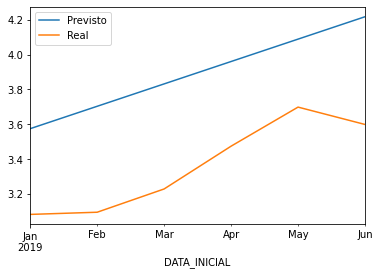

In [53]:
prediction.plot(label='Previsto')
data_pern_test['PRECO_MEDIO_REVENDA'].plot(label='Real')
plt.legend()

In [54]:
hwes_mse = ((data_pern_test['PRECO_MEDIO_REVENDA'] - prediction) ** 2).mean()
hwes_mse

0.2904493032545013

In [55]:
mlflow.log_metric('hwes_mse', hwes_mse)

In [56]:
print(
    f'MSE SARIMAX: {sarimax_mse}\n'
    f'MSE Prophet: {prophet_mse}\n'
    f'MSE AutoRegression: {ar_mse}\n'
    f"MSE Holt Winter's Exponential Smoothing: {hwes_mse}\n"
)

MSE SARIMAX: 0.19769325390690984
MSE Prophet: 0.06854647912456395
MSE AutoRegression: 0.09793155747593428
MSE Holt Winter's Exponential Smoothing: 0.2904493032545013



O algoritmo Prophet apresentou o menor MSE, de forma que tentaremos melhorar sua performance em seguida. A ferramenta disponibilizada pelo Prophet para diagnósticos é uma função de validação cruzada periódica sobre um dataframe de treinamento, que deve se seguir de um Grid-Search para escolha de hiperparâmetros. Acontece que o Optuna já disponibiliza essa funcionalidade, portanto, rodaremos sua otimização novamente, com quantidade de tentativas consideravelmente maior.

In [57]:
prophet_final_study = optuna.create_study(direction="minimize")
prophet_final_study.optimize(prophet_objective, n_trials=300)

[I 2021-04-17 14:24:50,511] A new study created in memory with name: no-name-6d8f7741-77f3-4bfc-9e7f-bd5d7fe52034
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[I 2021-04-17 14:24:52,061] Trial 0 finished with value: 0.01721851140982111 and parameters: {'changepoint_prior_scale': 0.28267910158614273, 'seasonality_prior_scale': 6.108871924919028, 'holidays_prior_scale': 6.232856259089097}. Best is trial 0 with value: 0.01721851140982111.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[I 2021-04-17 14:24:53,523] Trial 1 finished with value: 0.016930696745544236 and parameters: {'changepoint_prior_scale': 0.15779094175487823, 'seasonality_prior_scale': 3.601247326706871, 'hol

[I 2021-04-17 14:25:18,047] Trial 17 finished with value: 0.014400877738653499 and parameters: {'changepoint_prior_scale': 0.05249358012156105, 'seasonality_prior_scale': 2.600868210722737, 'holidays_prior_scale': 1.0964155171404322}. Best is trial 10 with value: 0.014144162014882297.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[I 2021-04-17 14:25:19,593] Trial 18 finished with value: 0.014647094329945569 and parameters: {'changepoint_prior_scale': 0.4549312268364326, 'seasonality_prior_scale': 9.9790729369758, 'holidays_prior_scale': 2.726824496500038}. Best is trial 10 with value: 0.014144162014882297.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[I 2021-04-17 14:25:

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[I 2021-04-17 14:25:53,171] Trial 39 finished with value: 0.014161522600817345 and parameters: {'changepoint_prior_scale': 0.03401423570701245, 'seasonality_prior_scale': 4.034015319092515, 'holidays_prior_scale': 1.3320013788412375}. Best is trial 30 with value: 0.014040591393224874.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[I 2021-04-17 14:25:55,045] Trial 40 pruned. 
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[I 2021-04-17 14:25:56,617] Trial 41 finished with value: 0.014103295652897441 and parameters: {'changepoint_prior_scale': 0.031796717460087345, 'seasonal

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[I 2021-04-17 14:26:32,745] Trial 62 pruned. 
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[I 2021-04-17 14:26:34,349] Trial 63 finished with value: 0.01415689146590414 and parameters: {'changepoint_prior_scale': 0.04629744323580454, 'seasonality_prior_scale': 4.865645470280288, 'holidays_prior_scale': 1.6280438670057253}. Best is trial 45 with value: 0.013955262891536327.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[I 2021-04-17 14:26:36,016] Trial 64 pruned. 
INFO:

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[I 2021-04-17 14:27:10,494] Trial 85 pruned. 
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[I 2021-04-17 14:27:12,020] Trial 86 finished with value: 0.01410288432162122 and parameters: {'changepoint_prior_scale': 0.033820976051877845, 'seasonality_prior_scale': 3.8255211991452582, 'holidays_prior_scale': 1.4469968823781862}. Best is trial 45 with value: 0.013955262891536327.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[I 2021-04-17 14:27:13,616] Trial 87 pruned. 
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INF

[I 2021-04-17 14:27:47,660] Trial 109 pruned. 
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[I 2021-04-17 14:27:49,164] Trial 110 pruned. 
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[I 2021-04-17 14:27:50,698] Trial 111 finished with value: 0.014130421667260945 and parameters: {'changepoint_prior_scale': 0.03507688680284517, 'seasonality_prior_scale': 5.2097450429313295, 'holidays_prior_scale': 5.731511508446387}. Best is trial 45 with value: 0.013955262891536327.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[I 2021-04-17 14:28:27,923] Trial 134 pruned. 
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[I 2021-04-17 14:28:29,455] Trial 135 pruned. 
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[I 2021-04-17 14:28:31,026] Trial 136 finished with value: 0.014073833858466089 and parameters: {'changepoint_prior_scale': 0.04028175194400119, 'seasonality_prior_scale': 2.503112275275249, 'holidays_prior_scale': 2.04655458020496}. Best is trial 45 with value: 0.013955262891536327.
INF

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[I 2021-04-17 14:29:09,445] Trial 160 pruned. 
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[I 2021-04-17 14:29:10,981] Trial 161 finished with value: 0.014074716033455474 and parameters: {'changepoint_prior_scale': 0.04130224839919523, 'seasonality_prior_scale': 4.098891442686946, 'holidays_prior_scale': 1.1771260466693798}. Best is trial 45 with value: 0.013955262891536327.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[I 2021-04-17 14:29:12,418] Trial 162 pruned. 
I

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[I 2021-04-17 14:29:46,811] Trial 185 pruned. 
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[I 2021-04-17 14:29:48,256] Trial 186 pruned. 
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[I 2021-04-17 14:29:49,719] Trial 187 pruned. 
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[I 2021-04-17 14:29:51,202] Trial 1

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[I 2021-04-17 14:30:23,379] Trial 209 pruned. 
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[I 2021-04-17 14:30:24,904] Trial 210 pruned. 
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[I 2021-04-17 14:30:26,349] Trial 211 finished with value: 0.013973382981960361 and parameters: {'changepoint_prior_scale': 0.03984452108126356, 'seasonality_prior_scale': 1.8871972592299133, 'holidays_prior_scale': 1.1586301371241363}. Best is trial 45 with value: 0.013955262891536327.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[I 2021-04-17 14:31:00,923] Trial 234 pruned. 
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[I 2021-04-17 14:31:02,429] Trial 235 pruned. 
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[I 2021-04-17 14:31:03,875] Trial 236 finished with value: 0.01409941703445366 and parameters: {'changepoint_prior_scale': 0.034022642853356364, 'seasonality_prior_scale': 6.528233115463589, 'holidays_prior_scale': 1.3992905809426237}. Best is trial 45 with value: 0.013955262891536327.
I

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[I 2021-04-17 14:31:39,794] Trial 260 finished with value: 0.014050510056238079 and parameters: {'changepoint_prior_scale': 0.03819881129954335, 'seasonality_prior_scale': 3.1928814566744967, 'holidays_prior_scale': 1.4083189894643109}. Best is trial 45 with value: 0.013955262891536327.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[I 2021-04-17 14:31:41,247] Trial 261 pruned. 
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[I 2021-04-17 14:31:42,687] Trial 262 pruned. 
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


[I 2021-04-17 14:32:16,868] Trial 285 pruned. 
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[I 2021-04-17 14:32:18,497] Trial 286 pruned. 
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[I 2021-04-17 14:32:19,975] Trial 287 pruned. 
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[I 2021-04-17 14:32:21,404] Trial 288 pruned. 
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to ove

In [58]:
print_study_best_trial_params(prophet_final_study)

Melhor valor: 0.013955262891536327
Melhores parâmetros:
changepoint_prior_scale: 0.035238120177812866
seasonality_prior_scale: 5.193690722666086
holidays_prior_scale: 5.472175250495995


In [59]:
for param, val in prophet_final_study.best_trial.params.items():
    mlflow.log_param(f'final_prophet_{param}', val)

In [60]:
final_prophet = Prophet(**prophet_final_study.best_trial.params)
final_prophet.fit(prophet_df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [61]:
mlflow.sklearn.log_model(final_prophet, 'final_prophet')

In [62]:
future_df = final_prophet.make_future_dataframe(periods=6, freq='m')
future_pred = final_prophet.predict(future_df)

In [63]:
last_6_months = future_pred['yhat'][-6:].reset_index(drop=True)
last_6_months.index = data_pern_test.index

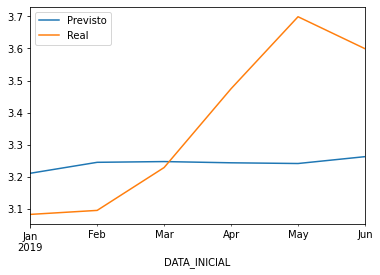

In [64]:
last_6_months.plot(label='Previsto')
data_pern_test['PRECO_MEDIO_REVENDA'].plot(label='Real')
plt.legend()

In [66]:
mse_final_prophet = ((data_pern_test['PRECO_MEDIO_REVENDA'] - last_6_months) ** 2).mean()
mse_final_prophet

0.06897829772404097

Finalmente, comparemos o novo MSE com o prévio

In [69]:
print(
    f'MSE Prophet Original: {prophet_mse}\n'
    f'MSE Prophet Final: {mse_final_prophet}'
)

MSE Prophet Original: 0.06854647912456395
MSE Prophet Final: 0.06897829772404097


Não foi possível obter melhora